# Generate plots to review filtering

After our filtering of cell type clusters for doublets and low gene expression, we need to generate visualizations to review the accuracy of our filtering process.

Here, we'll load the tables we generated during filtering to enable review for each cell type - cell metadata with labels, Louvain clusters, flags for filtering, and UMAP coordinates; tables of 

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }

quiet_library(cowplot)
quiet_library(data.table)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrastr)
quiet_library(hise)
quiet_library(purrr)
quiet_library(furrr)

In [2]:
plan(multisession, workers = 24)

## Helper functions

In [3]:
format_perc <- function(x, dec = 2) {
    format(round(x * 100, 2), nsmall = dec)
}

In [4]:
plot_clusters <- function(meta_df, cluster_col, plot_title) {
    color <- rlang::parse_expr(cluster_col)

    label_df <- meta_df %>%
      group_by(!!color) %>%
      summarise(umap_1 = median(umap_1),
                umap_2 = median(umap_2))
    
    ggplot() +
      geom_point_rast(
          data = meta_df,
          aes(x = umap_1,
              y = umap_2,
              color = !!color),
          size = 0.2
      ) +
      geom_text(
          data = label_df,
          aes(x = umap_1,
              y = umap_2,
              label = !!color)
      ) +
      scale_color_discrete() +
      scale_fill_discrete() +
      theme_bw() +
      ggtitle(plot_title)
}

In [5]:
plot_removal <- function(meta_df, color_df, plot_title) {

    label_df <- meta_df %>%
      group_by(remove_reason) %>%
      summarise(umap_1 = median(umap_1),
                umap_2 = median(umap_2))
    
    ggplot() +
      geom_point_rast(
          data = meta_df,
          aes(x = umap_1,
              y = umap_2,
              color = remove_reason),
          size = 0.2
      ) +
      geom_label(
          data = label_df,
          aes(x = umap_1,
              y = umap_2,
              label = remove_reason,
              fill = remove_reason)
      ) +
      scale_color_manual(
          breaks = color_df$remove_reason,
          values = color_df$remove_color
      ) +
      scale_fill_manual(
          breaks = color_df$remove_reason,
          values = color_df$remove_color
      ) +
      theme_bw() +
      ggtitle(plot_title)
}

In [6]:
plot_l3 <- function(meta_df, plot_title) {

    label_df <- meta_df %>%
      group_by(AIFI_L3) %>%
      summarise(umap_1 = median(umap_1),
                umap_2 = median(umap_2),
                n_cells = n()) %>%
      filter(n_cells > 100)
    
    ggplot() +
      geom_point_rast(
          data = meta_df,
          aes(x = umap_1,
              y = umap_2,
              color = AIFI_L3),
          size = 0.2
      ) +
      geom_label(
          data = label_df,
          aes(x = umap_1,
              y = umap_2,
              label = AIFI_L3)
      ) +
      scale_color_discrete() +
      scale_fill_discrete() +
      theme_bw() +
      theme(legend.position = "none") +
      ggtitle(plot_title)
}

In [7]:
plot_markers <- function(marker_df, filter_df, color_df) {
    
    filter_tiles <- filter_df %>%
      inner_join(marker_df %>% 
                  select(louvain_2, gene) %>%
                  unique(),
                 by = "louvain_2"
                )
    
    ggplot(marker_df) +
      geom_point( # Annoying extra hidden layer to make axes work
          data = marker_df,
          aes(x = louvain_2,
              y = gene),
          size = 0.1,
          alpha = 0
      ) +
      geom_tile(
          data = filter_tiles,
          aes(x = louvain_2,
              y = gene,
              color = remove_reason),
          linewidth = 1,
          fill = "white"
      ) +
      geom_point(
          data = marker_df,
          aes(x = louvain_2,
              y = gene,
              size = gene_frac,
              fill = log(gene_mean + 1)),
          pch = 21
      ) +
      scale_size_area() +
      scale_fill_gradientn(
          colors = c("black", "darkred", "red", "orangered", "orange")
      ) +
      scale_color_manual(
          breaks = color_df$remove_reason,
          values = color_df$remove_color
      ) +
      theme_bw() +
      theme(axis.ticks = element_blank())
}

In [8]:
plot_genes <- function(meta_df, color_df) {
    plot_df <- meta_df %>%
      left_join(color_df, by = "remove_reason")

    med_df <- plot_df %>%
      group_by(louvain_2) %>%
      summarise(med_genes = median(n_genes))
    
    ggplot() +
      geom_violin(
          data = meta_df,
          aes(x = louvain_2,
              y = log10(n_genes),
              fill = remove_reason)
      ) +
      geom_point(
          data = med_df,
          aes(x = louvain_2,
              y = log10(med_genes))
      ) +
      scale_fill_manual(
          breaks = color_df$remove_reason,
          values = color_df$remove_color
      ) +
      theme_bw()
}

In [9]:
plot_summary <- function(meta_df, color_df) {

    summary_df <- meta_df %>%
      group_by(remove_reason) %>%
      summarise(n_reason = n()) %>%
      ungroup() %>%
      mutate(perc_reason = format(round(n_reason / sum(n_reason) * 100,2), nsmall = 2)) %>%
      mutate(ypos = n():1)

    total_df <- data.frame(
        remove_reason = "Total removed",
        n_reason = sum(meta_df$remove_reason != "Not removed"),
        perc_reason = format_perc(sum(meta_df$remove_reason != "Not removed") / nrow(meta_df)),
        ypos = 0
    )

    header_df <- data.frame(
        label = c("Reason", "N", "%"),
        xpos = c(1, 2.4, 3),
        ypos = max(summary_df$ypos + 1),
        hjust = c(0, 1, 1)
    )

    summary_df <- rbind(summary_df, total_df)
    
    ggplot() +
      geom_rect(
          data = summary_df,
          aes(xmin = 0.9, xmax = 3.1,
              ymin = ypos - 0.5, ymax = ypos + 0.5,
              fill = remove_reason),
          alpha = 0.5
      ) +
      geom_text(
          data = header_df,
          aes(x = xpos, y = ypos,
              label = label, hjust = hjust)
      ) +
      geom_text(
          data = summary_df,
          aes(x = 1,
              y = ypos,
              label = remove_reason),
          hjust = 0
      ) +
      geom_text(
          data = summary_df,
          aes(x = 2.4,
              y = ypos,
              label = n_reason),
          hjust = 1
      ) +
      geom_text(
          data = summary_df,
          aes(x = 3,
              y = ypos,
              label = perc_reason),
          hjust = 1
      ) +
      scale_fill_manual(
          breaks = color_df$remove_reason,
          values = color_df$remove_color
      ) +
      scale_x_continuous("", expand = c(0,0)) +
      theme_bw() +
      theme(legend.position = "none",
            panel.grid = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.border = element_blank())
}

In [10]:
assemble_plots <- function(filter_df, marker_df, meta_df, color_df, group_name) {
    cluster_levels <- unique(meta_df$louvain_2) %>% sort()

    filter_df$louvain_2 <- factor(filter_df$louvain_2, levels = cluster_levels, ordered = TRUE)
    marker_df$louvain_2 <- factor(marker_df$louvain_2, levels = cluster_levels, ordered = TRUE)
    meta_df$louvain_2 <- factor(meta_df$louvain_2, levels = cluster_levels, ordered = TRUE)

    gene_order <- marker_df$gene %>% unique() %>% sort(decreasing = TRUE)
    marker_df$gene <- factor(marker_df$gene, levels = gene_order, ordered = TRUE)

    filter_df <- filter_df %>% left_join(reason_colors, by = "remove_reason")
    meta_df <- meta_df %>% left_join(reason_colors, by = "remove_reason")

    cluster_umap <- plot_clusters(meta_df, "louvain_2", group_name)
    removal_umap <- plot_removal(meta_df, reason_colors, group_name)
    l3_umap <- plot_l3(meta_df, group_name)
    marker_dotplot <- plot_markers(marker_df, filter_df, reason_colors)
    gene_violins <- plot_genes(meta_df, reason_colors)
    summary_table <- plot_summary(meta_df, reason_colors)
    
    blank_plot <- ggplot() + theme_bw() + theme(panel.border = element_blank())
    
    top_row <- plot_grid(cluster_umap, removal_umap, l3_umap, nrow = 1, ncol = 3)
    bottom_row <- plot_grid(
        marker_dotplot, summary_table,
        gene_violins, blank_plot,
        nrow = 2, ncol = 2,
        rel_heights = c(1, 0.5),
        rel_widths = c(0.8, 0.2)
    )
    all_plots <- plot_grid(
        top_row, 
        bottom_row,
        nrow = 2, ncol = 1
    )
    
    return(all_plots)
}

## Color values

In [11]:
reason_colors <- data.frame(
    remove_reason = c(
        "Not removed", "Total removed",
        "B cell doublet", "Erythrocyte doublet",
        "Myeloid doublet", "Platelet doublet", 
        "T cell doublet", "Low gene detection"
    ),
    remove_color = c(
        "#8efaa4", "#ffffff",
        "#fcb890", "#fa9c9b",
        "#b997f7", "#e6db8c",
        "#99acf2", "#8c8c8c"
    )
)

## Retrieve review files from HISE

These were stored as a .tar.gz archive to make transfer a bit easier. We'll pull down the .tar.gz then decompress and unbundle with a `system()` call.

In [12]:
review_uuid <- "02734d18-6531-4cbb-8162-a70c08413603"

In [13]:
cache_res <- cacheFiles(list(review_uuid))

In [14]:
review_tar_file <- list.files(paste0("cache/", review_uuid), full.names = TRUE)

In [15]:
untar_call <- paste("tar -xzf", review_tar_file)
system(untar_call)

Because of how they were stored in the originating instance, these will untar to the `output/review/` subfolder.

In [16]:
filter_files <- list.files("output/review", pattern = "filter_df", full.names = TRUE)
names(filter_files) <- sub(".+diha_qc_(.+)_filter.+", "\\1", filter_files)

marker_files <- list.files("output/review", pattern = "marker_df", full.names = TRUE)
names(marker_files) <- sub(".+diha_qc_(.+)_marker.+", "\\1", marker_files)

meta_files <- list.files("output/review", pattern = "obs_df", full.names = TRUE)
names(meta_files) <- sub(".+diha_qc_(.+)_obs.+", "\\1", meta_files)

In [17]:
group_names <- names(filter_files)

## Generate plots for every group

In [18]:
future_walk(
    group_names,
    function(group_name) {
        filter_file <- filter_files[group_name]
        marker_file <- marker_files[group_name]
        meta_file <- meta_files[group_name]

        filter_df <- as.data.frame(fread(filter_file))
        marker_df <- as.data.frame(fread(marker_file))
        meta_df <- as.data.frame(fread(meta_file))

        all_plots <- assemble_plots(
            filter_df, marker_df, meta_df,
            reason_colors, group_name
        )

        out_file <- paste0(
            "output/diha_filter-review_", 
            group_name, "_",
            Sys.Date(),
            ".png" 
        )
        
        ggsave(
            out_file,
            all_plots,
            width = 20, height = 12
        )
    }
)

## Generate summary tables and overview plots

In [19]:
all_meta <- map(meta_files, fread)

In [20]:
subject_visit_l2_summary <- map_dfr(
    all_meta,
    function(meta) {
        meta %>%
          group_by(subject.subjectGuid, sample.visitName, AIFI_L2, remove_reason) %>%
          count() %>%
          group_by(subject.subjectGuid, sample.visitName, AIFI_L2) %>%
          mutate(perc = format_perc(n / sum(n)))
    }
)

In [21]:
sample_summary_file <- paste0(
    "output/diha_filter-review_sample-summary_", 
    Sys.Date(), ".csv"
)
write.csv(
    subject_visit_l2_summary,
    sample_summary_file,
    row.names = FALSE,
    quote = FALSE
)

In [22]:
type_totals <- subject_visit_l2_summary %>%
  group_by(AIFI_L2) %>%
  mutate(total = sum(n)) %>%
  filter(remove_reason != "Not removed") %>%
  summarise(n = sum(n), 
            perc = format_perc(n / total[1]),
            .groups = "keep") %>%
  ungroup() %>%
  arrange(desc(n))

In [23]:
type_summary <- subject_visit_l2_summary %>%
  group_by(AIFI_L2, remove_reason) %>%
  summarise(n = sum(n), .groups = "keep") %>%
  group_by(AIFI_L2) %>%
  mutate(perc = format_perc(n / sum(n))) %>%
  mutate(AIFI_L2 = factor(AIFI_L2, levels = type_totals$AIFI_L2, ordered = TRUE))

In [24]:
type_summary_file <- paste0(
    "output/diha_filter-review_type-summary_", 
    Sys.Date(), ".csv"
)
write.csv(
    type_summary,
    type_summary_file,
    row.names = FALSE,
    quote = FALSE
)

In [25]:
options(repr.plot.width = 12, repr.plot.height = 4)
n_plot <- ggplot() +
  geom_col(
      data = type_summary %>%
        filter(remove_reason != "Not removed"),
      aes(x = AIFI_L2, y = n, fill = remove_reason)
  ) +
  scale_x_discrete(
      ""
  ) +
  scale_y_continuous(
      expand = c(0,0)
  ) +
  scale_fill_manual(
      breaks = reason_colors$remove_reason,
      values = reason_colors$remove_color
  ) +
  theme_bw() +
  theme(axis.text.x = element_blank(),
        axis.ticks = element_blank())

In [26]:
options(repr.plot.width = 12, repr.plot.height = 4)
perc_plot <- ggplot() +
  geom_col(
      data = type_summary %>%
        filter(remove_reason != "Not removed"),
      aes(x = AIFI_L2, y = as.numeric(perc), fill = remove_reason)
  ) +
  scale_x_discrete(
      ""
  ) +
  scale_y_continuous(
      "% of cells",
      expand = c(0,0)
  ) +
  scale_fill_manual(
      breaks = reason_colors$remove_reason,
      values = reason_colors$remove_color
  ) +
  theme_bw() +
  theme(axis.text.x = element_blank(),
        axis.ticks = element_blank())

In [27]:
options(repr.plot.width = 12, repr.plot.height = 4)
type_removal_summary <- type_summary %>%
  filter(remove_reason != "Not removed") %>%
  group_by(AIFI_L2) %>%
  mutate(total = sum(n)) %>%
  mutate(perc = format_perc(n / total))

removed_perc_plot <- ggplot() +
  geom_col(
      data = type_removal_summary,
      aes(x = AIFI_L2, y = as.numeric(perc), fill = remove_reason)
  ) +
  scale_y_continuous(
      "% of removed cells",
      expand = c(0,0)
  ) +
  scale_fill_manual(
      breaks = reason_colors$remove_reason,
      values = reason_colors$remove_color
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank())

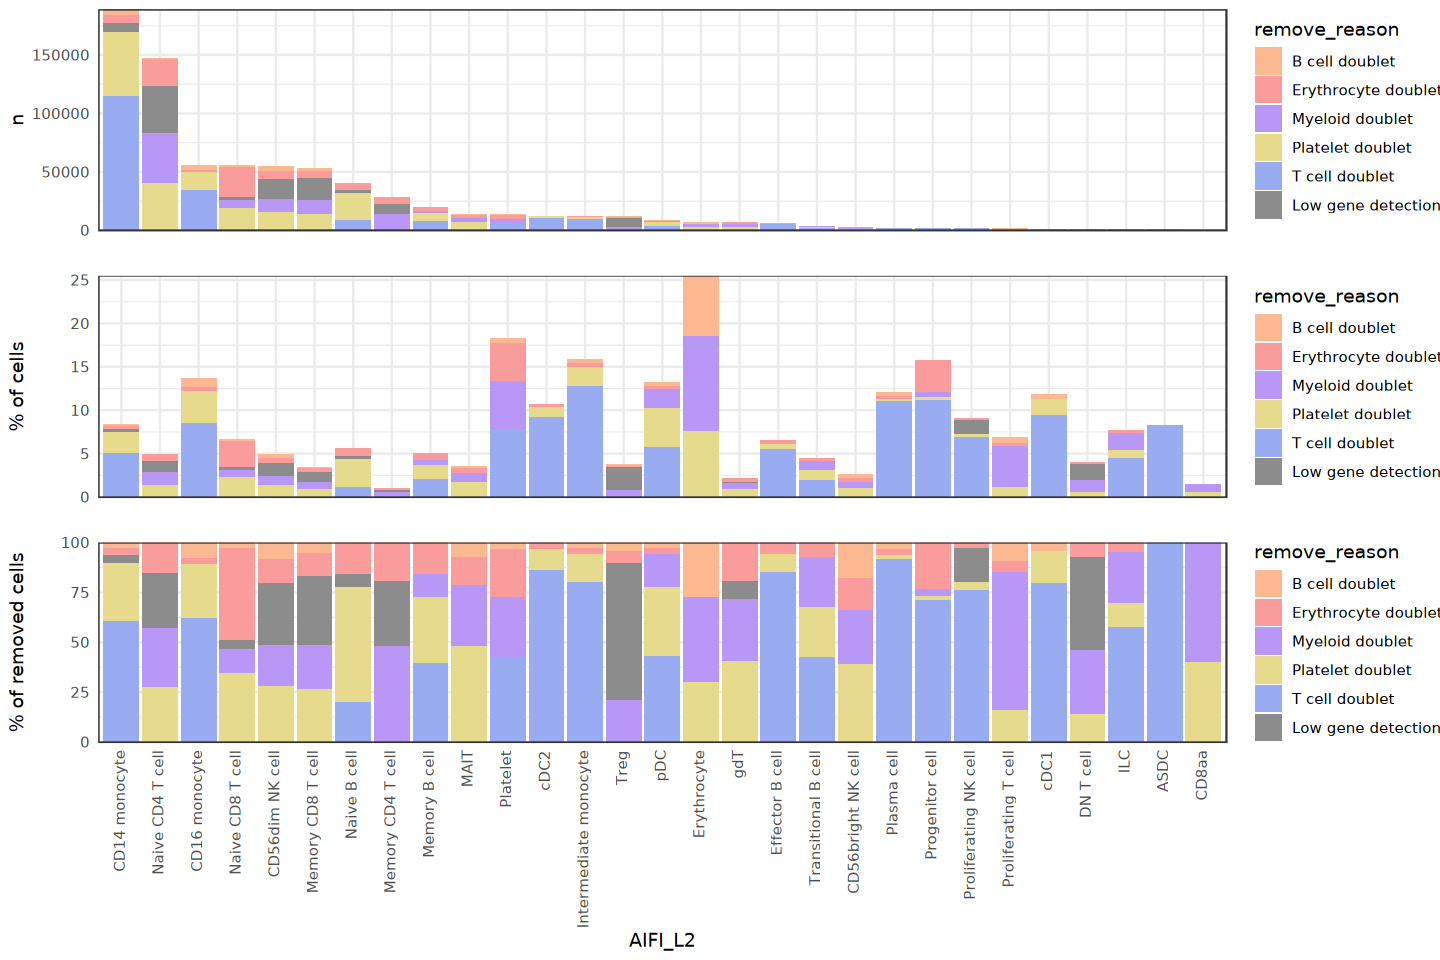

In [28]:
options(repr.plot.width = 12, repr.plot.height = 8)
summary_plot <- plot_grid(
    n_plot,
    perc_plot,
    removed_perc_plot,
    nrow = 3,
    ncol = 1,
    rel_heights = c(1,1,1.6),
    align = "v"
)
summary_plot

In [29]:
summary_file <- paste0("output/diha_filter-overview_",Sys.Date(),".png")
ggsave(
    summary_file,
    summary_plot,
    width = 12, height = 8
)

In [30]:
all_summary <- subject_visit_l2_summary %>%
  group_by(remove_reason) %>%
  summarise(n = sum(n), .groups = "keep") %>%
  ungroup() %>%
  mutate(perc = format_perc(n / sum(n))) %>%
  arrange(desc(n))

all_total <- data.frame(
    remove_reason = "Total removed",
    n = sum(all_summary$n[all_summary$remove_reason != "Not removed"]),
    perc = sum(as.numeric(all_summary$perc[all_summary$remove_reason != "Not removed"]))
)

all_summary <- rbind(all_summary, all_total)

In [31]:
all_summary

remove_reason,n,perc
<chr>,<int>,<chr>
Not removed,14082507,94.96
Platelet doublet,207358,1.40
T cell doublet,206056,1.39
Myeloid doublet,108489,0.73
Low gene detection,106434,0.72
Erythrocyte doublet,94036,0.63
B cell doublet,25142,0.17
Total removed,747515,5.04


In [32]:
global_summary_file <- paste0(
    "output/diha_filter-review_global-summary_", 
    Sys.Date(), ".csv"
)
write.csv(
    all_summary,
    global_summary_file,
    row.names = FALSE,
    quote = FALSE
)

In [33]:
tar_file <- paste0(
    "output/diha_filter-review_figures_",
    Sys.Date(),
    ".tar"
)

system(paste("tar -cf", tar_file, "output/*.png"))

## Store results in HISE

We'll store the .tar file containing all of our images and the summary table .csv files in HISE for later reference.

In [34]:
study_space_uuid <- "de025812-5e73-4b3c-9c3b-6d0eac412f2a"
title <- paste("DIHA Cleanup Review Materials", Sys.Date())

In [35]:
in_list <- list(review_uuid)

In [36]:
out_list <- list(
    tar_file, 
    sample_summary_file,
    type_summary_file, 
    global_summary_file
)

In [37]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/diha_filter-review_figures_2024-03-17.tar"

$files[[2]]
[1] "output/diha_filter-review_sample-summary_2024-03-17.csv"

$files[[3]]
[1] "output/diha_filter-review_type-summary_2024-03-17.csv"

$files[[4]]
[1] "output/diha_filter-review_global-summary_2024-03-17.csv"


$traceId
[1] "0437b333-62e8-4a51-af5c-d84eb0cb89a6"

In [38]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] furrr_0.3.1       future_1.33.1     purrr_1.0.2       hise_2.16.0      
[5] ggrastr_1.0.2     ggplot2_3.4.4     dplyr_1.1.4       data.table_1.15.0
[9] cowplot_1.1.2    

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    bitops_1.0-7      stringi_1.8.3    
 [5] listenv_0.9.0